# Adaptive-IPP with Non-Point FoV

In [1]:
import os
os.environ["TF_ENABLE_ONEDNN_OPTS"] = "0"

import numpy as np

from sgptools.utils.metrics import *
from sgptools.utils.data import *
from sgptools.utils.misc import *
from sgptools.models.core.osgpr import *
from sgptools.utils.tsp import run_tsp
from sgptools.utils.gpflow import get_model_params
from sgptools.models.continuous_sgp import *
from sgptools.models.core.transformations import *
from gpflow.utilities.traversal import print_summary

from matplotlib import colors
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
import mpl_toolkits.mplot3d.art3d as art3d
from scipy.optimize import linear_sum_assignment
from sklearn.metrics import pairwise_distances

from time import time
from copy import deepcopy

np.random.seed(1234)
tf.random.set_seed(1234)

2025-06-05 10:35:45.392759: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-06-05 10:35:45.401776: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-06-05 10:35:45.430704: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749137745.476034   42651 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749137745.487590   42651 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1749137745.521702   42651 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linkin

In [2]:
'''
Utility to map the inducing points to FoV vertices
'''
def get_vertices(Xu, X_fov):
    X_fov = X_fov.reshape(len(Xu), -1, 2)
    vertices = np.zeros((len(Xu), 5, 2))
    vertices[:, 0] = X_fov.min(axis=1)
    vertices[:, 1] = np.array([X_fov[:, :, 0].min(axis=1), 
                              X_fov[:, :, 1].max(axis=1)]).T
    vertices[:, 2] = X_fov.max(axis=1)
    vertices[:, 3] = np.array([X_fov[:, :, 0].max(axis=1), 
                              X_fov[:, :, 1].min(axis=1)]).T
    vertices[:, 4] = X_fov.mean(axis=1)

    dists = pairwise_distances(vertices[:, 4], Y=Xu[:, :2], 
                               metric='euclidean')
    _, idx = linear_sum_assignment(dists)

    vertices[:, 4] = Xu[idx][:, :2]
    return vertices

'''
Method to plot the solution with FoVs and environment reconstruction
'''
def plot_results(X_inducing, X_fov, current_idx=0, fname=None):
    # Setup 3D plot
    fig = plt.figure(figsize=(5, 5))
    ax = fig.add_subplot(111, projection='3d', computed_zorder=False)

    current_idx += 1 # Increment by one for plotting

    # Plot the reconstructed environment state
    num_fov_pts = len(X_fov)//len(X_inducing)
    sensor_data = cont2disc(X_fov[:num_fov_pts*(current_idx)], X, y)
    y_pred, _ = get_reconstruction(sensor_data, X_test, 
                                   noise_variance_opt, kernel_opt)
    norm = colors.Normalize(y_train.min(), y_train.max())
    _ = ax.plot_surface(X_test[:, 0].reshape(test_dim),
                        X_test[:, 1].reshape(test_dim),
                        np.atleast_2d(-0.1),
                        facecolors=plt.cm.jet(norm(y_pred.reshape(test_dim))),
                        shade=False,
                        alpha=0.8,
                        zorder=0)

    # Plot the solution path
    ax.scatter(X_inducing[:current_idx, 0], 
               X_inducing[:current_idx, 1], 
               X_inducing[:current_idx, 2], c='C3')
    ax.scatter(X_inducing[current_idx:, 0], 
               X_inducing[current_idx:, 1], 
               X_inducing[current_idx:, 2], c='C2')
    ax.plot(X_inducing[:, 0], X_inducing[:, 1], X_inducing[:, 2], 'k-')

    # Plot the FoV vertices
    vertices = get_vertices(X_inducing, X_fov)
    for i in range(vertices.shape[0]):
        color = 'C3' if i < current_idx else 'C2'
        verts = []
        verts.append([vertices[i, 0], vertices[i, 1], 
                      vertices[i, 2], vertices[i, 3]])
        fov = Polygon(np.array(verts)[0, :, :2],
                      linewidth=1.5, 
                      edgecolor=color,
                      facecolor=color,
                      fill=False,
                      zorder=15)
        ax.add_patch(fov)
        art3d.pathpatch_2d_to_3d(fov)

    # Configure other plot settings
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')

    ax.set_xlim(np.min(X[:, 0])-0.5, np.max(X[:, 0])+0.5)
    ax.set_ylim(np.min(X[:, 1])-0.5, np.max(X[:, 1])+0.5)
    ax.set_zlim(0, 14)

    ax.view_init(elev=30, azim=45+180)
    ax.set_title(f'Waypoint: {current_idx}, RMSE: {get_rmse(y_pred, y_test):.2f}\nData Field Reconstruction', y=0.99)

    plt.tight_layout()
    if fname is not None:
        plt.savefig(fname, bbox_inches='tight')
    plt.show()

In [3]:
'''
Method to run AIPP using the SGP-based approach
'''
def run_aipp(X_train, ipp_model, Xu_init, path2data):
    total_time_param = 0
    total_time_ipp = 0
    num_robots = Xu_init.shape[0]
    num_waypoints = Xu_init.shape[1]
    curr_sol = Xu_init
    plot_results(ipp_model.transform.expand(curr_sol.reshape(-1, 3), 
                                            expand_sensor_model=False).numpy(),
                 ipp_model.transform.expand(curr_sol.reshape(-1, 3)).numpy())

    # Initialize the hyperparameters and SSGP
    init_kernel = deepcopy(ipp_model.kernel)
    init_noise_variance = ipp_model.likelihood.variance
    param_model = init_osgpr(X_train, 
                             num_inducing=40, 
                             kernel=init_kernel,
                             noise_variance=init_noise_variance)

    sol_data_X = []
    sol_data_y = []
    for time_step in range(num_waypoints):
        # Get a new batch of data from the last visited waypoint
        last_visited = curr_sol[:, time_step].copy()
        # Apply the sensor model expansion with fixed points IPP expansion
        data_pts = ipp_model.transform.sensor_model.expand(last_visited).numpy()
        data_X_batch, data_y_batch = path2data(data_pts)
        sol_data_X.extend(data_X_batch)
        sol_data_y.extend(data_y_batch)

        # Skip param and path update for the last waypoint
        if time_step == num_waypoints-1:
            break

        # Update the SSGP hyperparameter model
        param_model.update((np.array(data_X_batch), 
                            np.array(data_y_batch)),
                            update_inducing=False)
        # Train only the kernel parameters and noise variance.
        # Keeping the SSGP inducing points fixed results in better 
        # hyperparameter estimation
        start_time = time()
        optimize_model(param_model, 
                       trainable_variables=param_model.trainable_variables, 
                       optimizer='scipy',
                       method='CG')
        end_time = time()
        total_time_param += end_time - start_time
        print_summary(param_model.kernel)

        # Update the SGP-IPP model
        Xu_visited = curr_sol.copy()[:, :time_step+1]
        ipp_model.transform.update_Xu_fixed(Xu_visited)
        ipp_model.update(param_model.likelihood.variance, 
                         param_model.kernel)
        start_time = time()
        _ = optimize_model(ipp_model,
                           kernel_grad=False, 
                           optimizer='scipy',
                           method='CG')
        end_time = time()
        total_time_ipp += end_time - start_time
        curr_sol = ipp_model.inducing_variable.Z
        curr_sol = ipp_model.transform.expand(curr_sol, 
                                              expand_sensor_model=False).numpy()
        curr_sol = curr_sol.reshape(num_robots, num_waypoints, 3)

        plot_results(ipp_model.transform.expand(curr_sol.reshape(-1, 3),
                                                expand_sensor_model=False).numpy(),
                     ipp_model.transform.expand(curr_sol.reshape(-1, 3)).numpy(),
                     time_step+1)

    return np.array(sol_data_X), np.array(sol_data_y), total_time_param, total_time_ipp

## Generate synthetic data and initial SGP hyperparameters

Optimized Hyperparameters


2025-06-05 10:35:56.955401: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


╒═════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤═════════════════════╕
│ name                    │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │ value               │
╞═════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪═════════════════════╡
│ GPR.kernel.variance     │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │ 0.835314440520438   │
├─────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼─────────────────────┤
│ GPR.kernel.lengthscales │ Parameter │ Softplus         │         │ True        │ (2,)    │ float64 │ [2.45062 2.50311]   │
├─────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼─────────────────────┤
│ GPR.likelihood.variance │ Parameter │ Softplus + Shift │         │ True        │ ()      │ float64 │ 0.04333551394798675 │


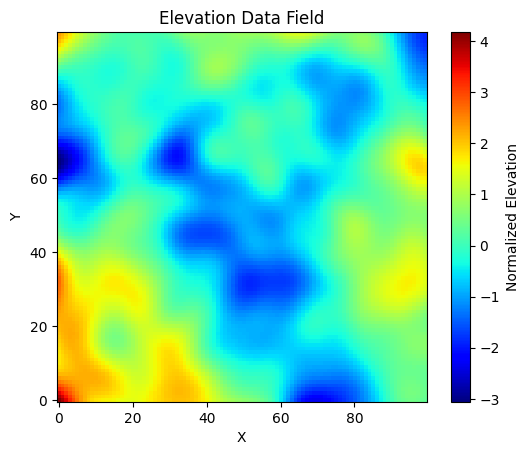

In [4]:
# Get the synthetic elevation data
X_train, y_train, X_test, y_test, candidates, X, y = get_dataset(random_seed=0)
train_dim = np.sqrt(X_train.shape[0]).astype(int)

# Train a GP and get the model parameters
print('Optimized Hyperparameters')
_, noise_variance_opt, kernel_opt = get_model_params(X_train, y_train, 
                                                     lengthscales=[1.0, 1.0], 
                                                     optimizer='scipy')

# Build a new test set on a grid for easy plotting in a 3D plot
gpr = gpflow.models.GPR((X_test, y_test),
                        noise_variance=noise_variance_opt,
                        kernel=kernel_opt)
test_dim = (100, 100)
X_test1 = np.linspace(np.min(X[:, 0]), np.max(X[:, 0]), test_dim[0])
X_test2 = np.linspace(np.min(X[:, 1]), np.max(X[:, 1]), test_dim[1])
X_test1, X_test2 = np.meshgrid(X_test1, X_test2)
X_test = np.stack([X_test1.ravel(), X_test2.ravel()], axis=1)
y_test, y_var = gpr.predict_f(X_test)
y_test = y_test.numpy()

# Plot the data field
plt.imshow(y_test.reshape(test_dim), cmap="jet", origin='lower')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Elevation Data Field')
plt.colorbar(label='Normalized Elevation')
plt.show()

## Generate the AIPP solution

Initial AIPP Hyperparameters
╒═════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤═════════════════════╕
│ name                    │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │ value               │
╞═════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪═════════════════════╡
│ GPR.kernel.variance     │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │ 1.0                 │
├─────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼─────────────────────┤
│ GPR.kernel.lengthscales │ Parameter │ Softplus         │         │ True        │ (2,)    │ float64 │ [1. 1.]             │
├─────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼─────────────────────┤
│ GPR.likelihood.variance │ Parameter │ Softplus + Shift │         │ True        │ ()      │ flo

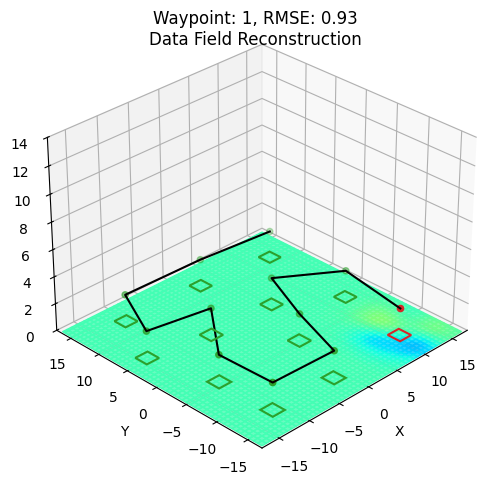

╒═════════════════════════════════╤═══════════╤═════════════╤═════════╤═════════════╤═════════╤═════════╤══════════════════════╕
│ name                            │ class     │ transform   │ prior   │ trainable   │ shape   │ dtype   │ value                │
╞═════════════════════════════════╪═══════════╪═════════════╪═════════╪═════════════╪═════════╪═════════╪══════════════════════╡
│ SquaredExponential.variance     │ Parameter │ Softplus    │         │ True        │ ()      │ float64 │ 0.040362121499937856 │
├─────────────────────────────────┼───────────┼─────────────┼─────────┼─────────────┼─────────┼─────────┼──────────────────────┤
│ SquaredExponential.lengthscales │ Parameter │ Softplus    │         │ True        │ (2,)    │ float64 │ [1.81417 2.66686]    │
╘═════════════════════════════════╧═══════════╧═════════════╧═════════╧═════════════╧═════════╧═════════╧══════════════════════╛


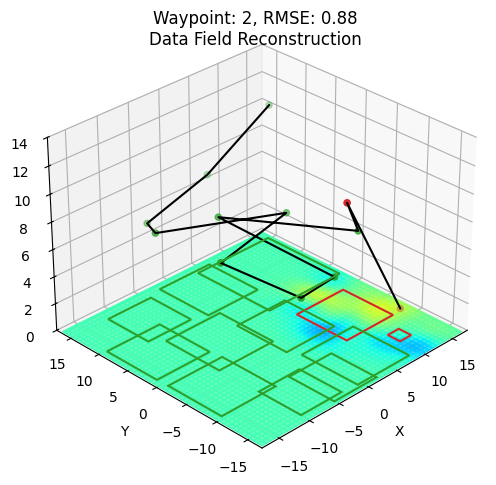

╒═════════════════════════════════╤═══════════╤═════════════╤═════════╤═════════════╤═════════╤═════════╤═════════════════════╕
│ name                            │ class     │ transform   │ prior   │ trainable   │ shape   │ dtype   │ value               │
╞═════════════════════════════════╪═══════════╪═════════════╪═════════╪═════════════╪═════════╪═════════╪═════════════════════╡
│ SquaredExponential.variance     │ Parameter │ Softplus    │         │ True        │ ()      │ float64 │ 0.16592046486249215 │
├─────────────────────────────────┼───────────┼─────────────┼─────────┼─────────────┼─────────┼─────────┼─────────────────────┤
│ SquaredExponential.lengthscales │ Parameter │ Softplus    │         │ True        │ (2,)    │ float64 │ [2.72283 4.30756]   │
╘═════════════════════════════════╧═══════════╧═════════════╧═════════╧═════════════╧═════════╧═════════╧═════════════════════╛


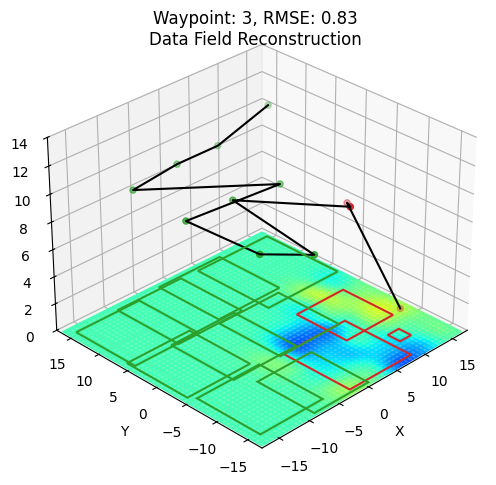

╒═════════════════════════════════╤═══════════╤═════════════╤═════════╤═════════════╤═════════╤═════════╤═════════════════════╕
│ name                            │ class     │ transform   │ prior   │ trainable   │ shape   │ dtype   │ value               │
╞═════════════════════════════════╪═══════════╪═════════════╪═════════╪═════════════╪═════════╪═════════╪═════════════════════╡
│ SquaredExponential.variance     │ Parameter │ Softplus    │         │ True        │ ()      │ float64 │ 0.23089586792688174 │
├─────────────────────────────────┼───────────┼─────────────┼─────────┼─────────────┼─────────┼─────────┼─────────────────────┤
│ SquaredExponential.lengthscales │ Parameter │ Softplus    │         │ True        │ (2,)    │ float64 │ [4.08975 3.55167]   │
╘═════════════════════════════════╧═══════════╧═════════════╧═════════╧═════════════╧═════════╧═════════╧═════════════════════╛


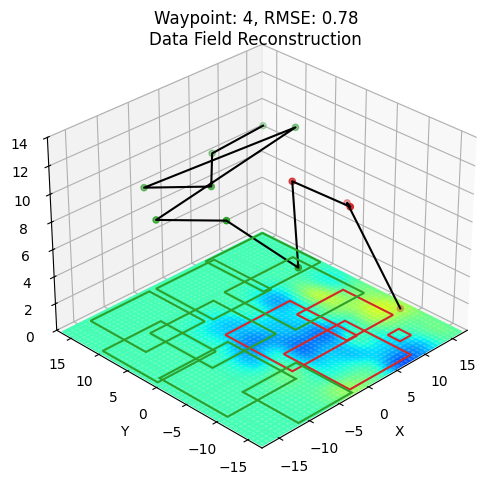

╒═════════════════════════════════╤═══════════╤═════════════╤═════════╤═════════════╤═════════╤═════════╤═════════════════════╕
│ name                            │ class     │ transform   │ prior   │ trainable   │ shape   │ dtype   │ value               │
╞═════════════════════════════════╪═══════════╪═════════════╪═════════╪═════════════╪═════════╪═════════╪═════════════════════╡
│ SquaredExponential.variance     │ Parameter │ Softplus    │         │ True        │ ()      │ float64 │ 0.23533310106368985 │
├─────────────────────────────────┼───────────┼─────────────┼─────────┼─────────────┼─────────┼─────────┼─────────────────────┤
│ SquaredExponential.lengthscales │ Parameter │ Softplus    │         │ True        │ (2,)    │ float64 │ [4.00236 3.09196]   │
╘═════════════════════════════════╧═══════════╧═════════════╧═════════╧═════════════╧═════════╧═════════╧═════════════════════╛


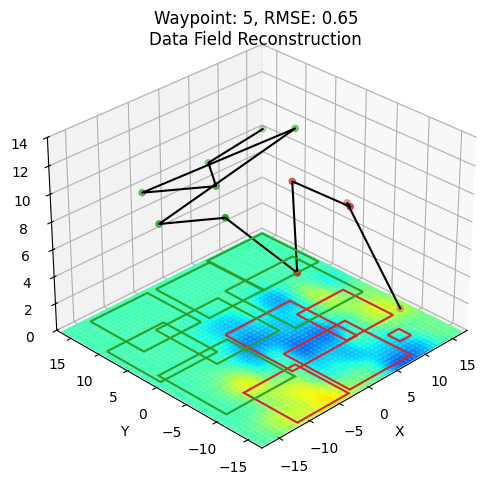

╒═════════════════════════════════╤═══════════╤═════════════╤═════════╤═════════════╤═════════╤═════════╤═════════════════════╕
│ name                            │ class     │ transform   │ prior   │ trainable   │ shape   │ dtype   │ value               │
╞═════════════════════════════════╪═══════════╪═════════════╪═════════╪═════════════╪═════════╪═════════╪═════════════════════╡
│ SquaredExponential.variance     │ Parameter │ Softplus    │         │ True        │ ()      │ float64 │ 0.39045166350536964 │
├─────────────────────────────────┼───────────┼─────────────┼─────────┼─────────────┼─────────┼─────────┼─────────────────────┤
│ SquaredExponential.lengthscales │ Parameter │ Softplus    │         │ True        │ (2,)    │ float64 │ [5.27442 3.60001]   │
╘═════════════════════════════════╧═══════════╧═════════════╧═════════╧═════════════╧═════════╧═════════╧═════════════════════╛


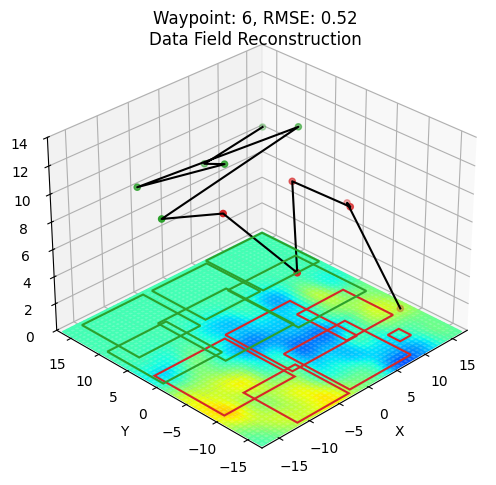

╒═════════════════════════════════╤═══════════╤═════════════╤═════════╤═════════════╤═════════╤═════════╤═════════════════════╕
│ name                            │ class     │ transform   │ prior   │ trainable   │ shape   │ dtype   │ value               │
╞═════════════════════════════════╪═══════════╪═════════════╪═════════╪═════════════╪═════════╪═════════╪═════════════════════╡
│ SquaredExponential.variance     │ Parameter │ Softplus    │         │ True        │ ()      │ float64 │ 0.43985270067009985 │
├─────────────────────────────────┼───────────┼─────────────┼─────────┼─────────────┼─────────┼─────────┼─────────────────────┤
│ SquaredExponential.lengthscales │ Parameter │ Softplus    │         │ True        │ (2,)    │ float64 │ [4.82156 4.03309]   │
╘═════════════════════════════════╧═══════════╧═════════════╧═════════╧═════════════╧═════════╧═════════╧═════════════════════╛


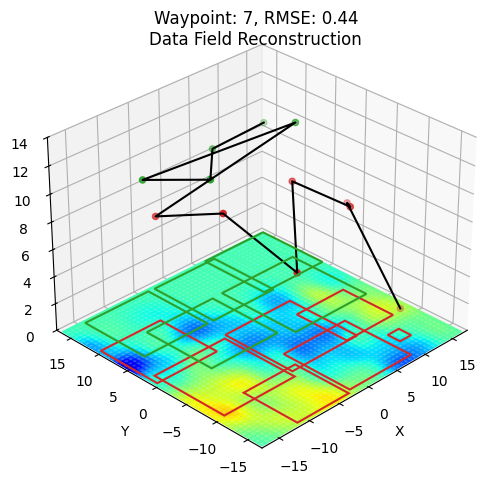

╒═════════════════════════════════╤═══════════╤═════════════╤═════════╤═════════════╤═════════╤═════════╤════════════════════╕
│ name                            │ class     │ transform   │ prior   │ trainable   │ shape   │ dtype   │ value              │
╞═════════════════════════════════╪═══════════╪═════════════╪═════════╪═════════════╪═════════╪═════════╪════════════════════╡
│ SquaredExponential.variance     │ Parameter │ Softplus    │         │ True        │ ()      │ float64 │ 0.5259930585781507 │
├─────────────────────────────────┼───────────┼─────────────┼─────────┼─────────────┼─────────┼─────────┼────────────────────┤
│ SquaredExponential.lengthscales │ Parameter │ Softplus    │         │ True        │ (2,)    │ float64 │ [4.64265 3.93746]  │
╘═════════════════════════════════╧═══════════╧═════════════╧═════════╧═════════════╧═════════╧═════════╧════════════════════╛


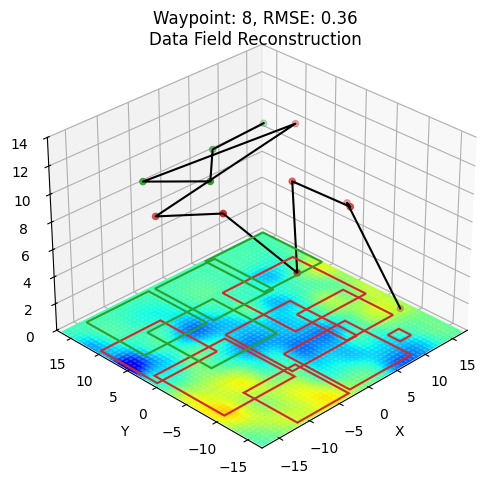

╒═════════════════════════════════╤═══════════╤═════════════╤═════════╤═════════════╤═════════╤═════════╤═════════════════════╕
│ name                            │ class     │ transform   │ prior   │ trainable   │ shape   │ dtype   │ value               │
╞═════════════════════════════════╪═══════════╪═════════════╪═════════╪═════════════╪═════════╪═════════╪═════════════════════╡
│ SquaredExponential.variance     │ Parameter │ Softplus    │         │ True        │ ()      │ float64 │ 0.44354567095640063 │
├─────────────────────────────────┼───────────┼─────────────┼─────────┼─────────────┼─────────┼─────────┼─────────────────────┤
│ SquaredExponential.lengthscales │ Parameter │ Softplus    │         │ True        │ (2,)    │ float64 │ [5.50776 3.32811]   │
╘═════════════════════════════════╧═══════════╧═════════════╧═════════╧═════════════╧═════════╧═════════╧═════════════════════╛


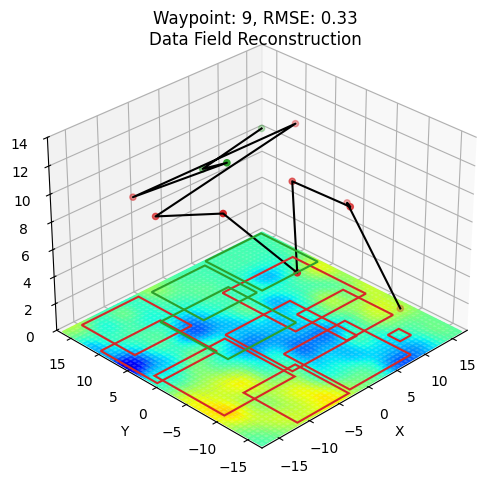

╒═════════════════════════════════╤═══════════╤═════════════╤═════════╤═════════════╤═════════╤═════════╤════════════════════╕
│ name                            │ class     │ transform   │ prior   │ trainable   │ shape   │ dtype   │ value              │
╞═════════════════════════════════╪═══════════╪═════════════╪═════════╪═════════════╪═════════╪═════════╪════════════════════╡
│ SquaredExponential.variance     │ Parameter │ Softplus    │         │ True        │ ()      │ float64 │ 0.3394591418768833 │
├─────────────────────────────────┼───────────┼─────────────┼─────────┼─────────────┼─────────┼─────────┼────────────────────┤
│ SquaredExponential.lengthscales │ Parameter │ Softplus    │         │ True        │ (2,)    │ float64 │ [4.26623 3.26859]  │
╘═════════════════════════════════╧═══════════╧═════════════╧═════════╧═════════════╧═════════╧═════════╧════════════════════╛


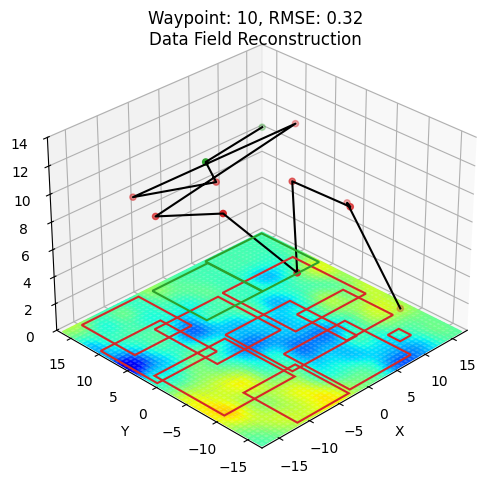

╒═════════════════════════════════╤═══════════╤═════════════╤═════════╤═════════════╤═════════╤═════════╤════════════════════╕
│ name                            │ class     │ transform   │ prior   │ trainable   │ shape   │ dtype   │ value              │
╞═════════════════════════════════╪═══════════╪═════════════╪═════════╪═════════════╪═════════╪═════════╪════════════════════╡
│ SquaredExponential.variance     │ Parameter │ Softplus    │         │ True        │ ()      │ float64 │ 0.4199022858396547 │
├─────────────────────────────────┼───────────┼─────────────┼─────────┼─────────────┼─────────┼─────────┼────────────────────┤
│ SquaredExponential.lengthscales │ Parameter │ Softplus    │         │ True        │ (2,)    │ float64 │ [4.78939 3.23059]  │
╘═════════════════════════════════╧═══════════╧═════════════╧═════════╧═════════════╧═════════╧═════════╧════════════════════╛


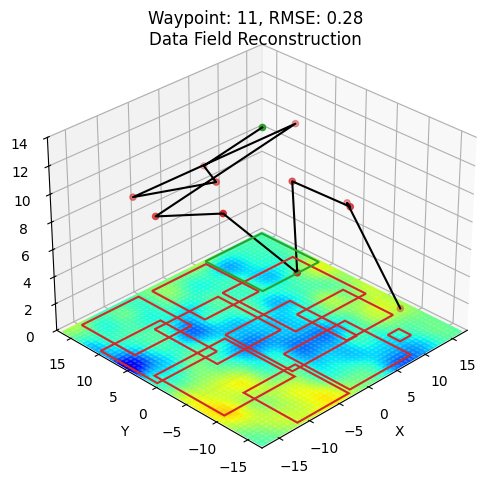

╒═════════════════════════════════╤═══════════╤═════════════╤═════════╤═════════════╤═════════╤═════════╤═════════════════════╕
│ name                            │ class     │ transform   │ prior   │ trainable   │ shape   │ dtype   │ value               │
╞═════════════════════════════════╪═══════════╪═════════════╪═════════╪═════════════╪═════════╪═════════╪═════════════════════╡
│ SquaredExponential.variance     │ Parameter │ Softplus    │         │ True        │ ()      │ float64 │ 0.47440805376685713 │
├─────────────────────────────────┼───────────┼─────────────┼─────────┼─────────────┼─────────┼─────────┼─────────────────────┤
│ SquaredExponential.lengthscales │ Parameter │ Softplus    │         │ True        │ (2,)    │ float64 │ [5.29191 3.66243]   │
╘═════════════════════════════════╧═══════════╧═════════════╧═════════╧═════════════╧═════════╧═════════╧═════════════════════╛


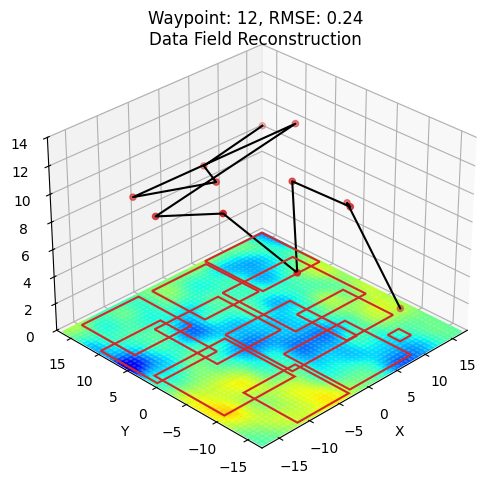

Total Hyperparameter Update Time:   47.83s
Total IPP Update Time:              58.13s
Average Hyperparameter Update Time: 3.99s
Average IPP Update Time:            4.84s


In [5]:
num_robots = 1
num_placements = 12
num_side = 7  # Use a num_side x num_side point FoV approximation

# Setup the initial AIPP hyperparameters
print('Initial AIPP Hyperparameters')
_, noise_variance, kernel = get_model_params(X_train, y_train, 
                                             lengthscales=[1.0, 1.0], 
                                             optimizer='scipy',
                                             max_steps=0)

# Get initial inducing points
Xu_init = get_inducing_pts(X_train, num_placements)
# Initalize the height dimension at 2.0 for all points
Xu_init = np.concatenate((Xu_init, np.ones((Xu_init.shape[0], 1))*2.0), axis=1)
Xu_init[:, :2] = run_tsp(Xu_init[:, :2])[0][0]

# Initialize the non-point FoV transform
fov_transform = SquareHeightTransform(num_side=num_side)
transform = IPPTransform(num_dim=3,
                         num_robots=1,
                         sensor_model=fov_transform,
                         aggregate_fov=True)

# Initialize the IPP model
sgpr, _ = continuous_sgp(num_placements,
                         X_train, 
                         noise_variance,
                         kernel,
                         transform=transform,
                         Xu_init=Xu_init,
                         max_steps=0)
sgp_sol_sp = sgpr.inducing_variable.Z.numpy()

# Setup the data acquisition function to emulate the robot's sensor
path2data = lambda x : cont2disc(x, X, y)

# Generate the SGP-based AIPP solution
_, _, param_time, ipp_time = run_aipp(X_train, 
                                      sgpr,
                                      Xu_init.reshape(1, -1, 3), 
                                      path2data)

print(f'Total Hyperparameter Update Time:   {param_time:.2f}s')
print(f'Total IPP Update Time:              {ipp_time:.2f}s')

print(f'Average Hyperparameter Update Time: {param_time/num_placements:.2f}s')
print(f'Average IPP Update Time:            {ipp_time/num_placements:.2f}s')